# Changes in QARTOD Gross Range and Climatology Lookup Tables

The lookup tables for gross range and climatology QARTOD tests on OOI CTDBP data were last updated on 12 Jan 2022, and the "suspect" ranges were calculated with all data before the cutoff date of 31 Dec 2021. However, when we recalculate these test ranges now, the values are different because recovered data that was recorded by the sensor before the cutoff date were recovered and ingested after the current lookup tables were published online. 

Deployment 14 of the Coastal Endurance array was the last deployment to be recovered before the cutoff date on 17 Sept 2021, so this is the last date that recovered instrument data was available for the original lookup tables. We can assume that deployment 14 data was included in the lookup table calculation since it was ingested on 18 Oct 2021. Since deployment 15 data was recovered 31 Mar 2022 and ingested xx xxx 2022, any gross range or climatology test ranges recalculated after 2023 with the same cutoff date will include additional recovered data from 17 Sept to 31 Dec 2021.

(Note: We could change the cutoff date to 17 Sept 2021 when calling on the script to recalculate the lookup tables, and see if that would result in the same lookup table values.)

In [1]:
# Load python modules used in this notebook into the workspace
import ooi_data_explorations.qartod.qc_processing as qc_process
import ooi_data_explorations.common as ooi_tools
from ooi_data_explorations.common import load_gc_thredds
from ooi_data_explorations.uncabled.process_ctdbp import ctdbp_datalogger, ctdbp_instrument

from ooinet import M2M

import numpy as np
import pandas as pd
import xarray as xr
import dask

In [14]:
# set parameters for a particular sensor
site = 'CE01ISSM'
node = 'MFD37'
sensor = '03-CTDBPC000'

refdes = '-'.join([site,node,sensor])

In [33]:
# Checking description of sensor with vocab connected to the reference designator above
vocab = M2M.get_vocab(refdes)
vocab

,@class,vocabId,refdes,instrument,tocL1,tocL2,tocL3,manufacturer,model,mindepth,maxdepth
0,.VocabRecord,14,CE01ISSM-MFD37-03-CTDBPC000,CTD,Coastal Endurance,Oregon Inshore Surface Mooring,Seafloor Multi-Function Node (MFN),Sea-Bird,SBE 16plusV2,25.0,25.0


In [4]:
# View deployment information 
# Below we can see the dates that instruments were recovered in relation to the date that lookup tables were updated and cutoff date.
deployments = M2M.get_deployments(refdes)
deployments.loc[10:12]

,deploymentNumber,uid,assetId,latitude,longitude,depth,deployStart,deployEnd,deployCruise,recoverCruise
10,14,CGINS-CTDBPC-50152,3483,44.65973,-124.09492,1.0,2021-03-31 14:29:00,2021-09-17 15:51:00,SKQ202104S,None
11,15,CGINS-CTDBPC-50055,1490,44.65708,-124.09447,1.0,2021-09-17 14:07:00,2022-03-31 00:06:00,TN394,None
12,16,CGINS-CTDBPC-50152,3483,44.65958,-124.095,1.0,2022-03-31 15:51:00,2022-10-01 16:21:00,SKQ202205S,None


### Finding dates of data ingestion

In [7]:
# Load metadata about the sensor to check available variables and attributes in the dataset
metadata = M2M.get_metadata(refdes)
metadata # Note that ingestion_timestamp exists as a variable for the data streams telemetered, recovered_host, and recovered_inst

,pdId,particleKey,type,shape,units,fillValue,stream,unsigned,method,count,beginTime,endTime,refdes
0,PD1,conductivity,FLOAT,SCALAR,S m-1,-9999999,ctdbp_cdef_dcl_instrument,False,telemetered,31047,2014-10-10T18:30:26.375Z,2023-05-22T12:30:05.914Z,CE01ISSM-SBD17-06-CTDBPC000
1,PD2,pressure,FLOAT,SCALAR,dbar,-9999999,ctdbp_cdef_dcl_instrument,False,telemetered,31047,2014-10-10T18:30:26.375Z,2023-05-22T12:30:05.914Z,CE01ISSM-SBD17-06-CTDBPC000
2,PD5,density,FLOAT,FUNCTION,kg m-3,-9999999,ctdbp_cdef_dcl_instrument,False,telemetered,31047,2014-10-10T18:30:26.375Z,2023-05-22T12:30:05.914Z,CE01ISSM-SBD17-06-CTDBPC000
3,PD6,temp,FLOAT,SCALAR,degrees_Celsius,-9999999,ctdbp_cdef_dcl_instrument,False,telemetered,31047,2014-10-10T18:30:26.375Z,2023-05-22T12:30:05.914Z,CE01ISSM-SBD17-06-CTDBPC000
4,PD7,time,DOUBLE,SCALAR,seconds since 1900-01-01,-9999999,ctdbp_cdef_dcl_instrument,False,telemetered,31047,2014-10-10T18:30:26.375Z,2023-05-22T12:30:05.914Z,CE01ISSM-SBD17-06-CTDBPC000
5,PD10,port_timestamp,DOUBLE,SCALAR,seconds since 1900-01-01,-9999999,ctdbp_cdef_dcl_instrument,False,telemetered,31047,2014-10-10T18:30:26.375Z,2023-05-22T12:30:05.914Z,CE01ISSM-SBD17-06-CTDBPC000
6,PD11,driver_timestamp,DOUBLE,SCALAR,seconds since 1900-01-01,-9999999,ctdbp_cdef_dcl_instrument,False,telemetered,31047,2014-10-10T18:30:26.375Z,2023-05-22T12:30:05.914Z,CE01ISSM-SBD17-06-CTDBPC000
7,PD12,internal_timestamp,DOUBLE,SCALAR,seconds since 1900-01-01,-9999999,ctdbp_cdef_dcl_instrument,False,telemetered,31047,2014-10-10T18:30:26.375Z,2023-05-22T12:30:05.914Z,CE01ISSM-SBD17-06-CTDBPC000
8,PD13,practical_salinity,FLOAT,FUNCTION,1,-9999999,ctdbp_cdef_dcl_instrument,False,telemetered,31047,2014-10-10T18:30:26.375Z,2023-05-22T12:30:05.914Z,CE01ISSM-SBD17-06-CTDBPC000
9,PD16,preferred_timestamp,STRING,SCALAR,None,empty,ctdbp_cdef_dcl_instrument,False,telemetered,31047,2014-10-10T18:30:26.375Z,2023-05-22T12:30:05.914Z,CE01ISSM-SBD17-06-CTDBPC000


The next cell is requesting and downloading data at the end of deployment 14. I temporarily edited the `m2m_collect()` function in the source code to keep the ingestion_timestep variable in the dataset instead of dropping it. Most of the time we won't need the ingestion timestamp, but in this case I needed to check which dates of recovered data were included in the calculation of published lookup tables.  

In [ ]:
# download recovered_host data on last day of deployment 14
tag = '.*CTDBP.*\\.nc$'
method = 'recovered_host'
stream = 'ctdbp_cdef_dcl_instrument_recovered'
req_host = ooi_tools.m2m_request(site, node, sensor, method, stream, start='2021-09-17T00:00:00.000Z', stop='2021-09-17T14:00:00.000Z')
data_host = ooi_tools.m2m_collect(req_host, tag)
data_host
# added data ingestion date in notes on OOI Data Explorations

In [ ]:
# download recovered_inst data on last day of deployment 14
tag = '.*CTDBP.*\\.nc$'
method = 'recovered_inst'
stream = 'ctdbp_cdef_instrument_recovered'
req_inst = ooi_tools.m2m_request(site, node, sensor, method, stream, start='2021-09-17T00:00:00.000Z', stop='2021-09-17T14:00:00.000Z')
data_inst = ooi_tools.m2m_collect(req_inst, tag)
data_inst
# added data ingestion date in notes on OOI Data Explorations

### Plotting temperature data from Sept to Dec 2021

From just adding 3 months of recovered data, the lower limit for the temperature gross range test increased by 45% of the original value for this reference designator. We are looking for anything significant in the time series that would explain a jump in the lower end of the 99.7% distribution of temperature measurements.

In [15]:
# Combine datasets from all 3 streams to plot the same timeseries that QARTOD test ranges are calculated from

# Import additional functions and modules for processing data and plotting
import os
from ooi_data_explorations.common import get_annotations, add_annotation_qc_flags
from ooi_data_explorations.qartod.endurance.qartod_ce_ctdbp import combine_delivery_methods
import matplotlib.pyplot as plt

# Define path on local machine to downloaded data
out_path = os.path.join(os.path.expanduser('~'), 'ooidata/m2m/', site.lower())
out_path = os.path.abspath(out_path)
if not os.path.exists(out_path):
    os.makedirs(out_path)
data_file = '-'.join([site, node, sensor]) + '.nc'

try:
    # Open the local dataset if it exists
    data = xr.load_dataset(os.path.join(out_path, data_file))
except:
    # Download and save data to a netcdf file to ooidata directory in user root
    data = combine_delivery_methods(site, node, sensor)
    data.to_netcdf(os.path.join(out_path, data_file), mode='w', format='NETCDF4', engine='h5netcdf')

In [16]:
# Use annotations to ignore any data that would be dropped before calculating test ranges
# get the current system annotations for the sensor
annotations = get_annotations(site, node, sensor)
annotations = pd.DataFrame(annotations)
if not annotations.empty:
    annotations = annotations.drop(columns=['@class'])
    annotations['beginDate'] = pd.to_datetime(annotations.beginDT, unit='ms').dt.strftime('%Y-%m-%dT%H:%M:%S')
    annotations['endDate'] = pd.to_datetime(annotations.endDT, unit='ms').dt.strftime('%Y-%m-%dT%H:%M:%S')

    # create an annotation-based quality flag
    data_edit = add_annotation_qc_flags(data, annotations)

    # clean-up the data, removing values that were marked as fail either from the quality checks or in the
    # annotations, and all data collected after the cut off date
    data_edit = data_edit.where(data_edit.rollup_annotations_qc_results != 4)

In [10]:
annotations


,id,subsite,node,sensor,method,stream,beginDT,endDT,annotation,exclusionFlag,source,qcFlag,parameters,beginDate,endDate
0,2342,CE01ISSM,None,None,recovered_host,None,1485949200000,1492458300000,The buoy and mfn battery voltages have been dr...,False,wingardc@oregonstate.edu,9,[],2017-02-01T11:40:00,2017-04-17T19:45:00
1,2576,CE01ISSM,SBD17,06-CTDBPC000,telemetered,None,1493757000000,1494970200000,"Due to bug in the data logger code, this perio...",False,kuebelb@oregonstate.edu,9,[],2017-05-02T20:30:00,2017-05-16T21:30:00
2,871,CE01ISSM,None,None,telemetered,None,1485949200000,1492458300000,The buoy and mfn battery voltages have been dr...,False,michaesm@marine.rutgers.edu,9,[],2017-02-01T11:40:00,2017-04-17T19:45:00
3,2577,CE01ISSM,SBD17,06-CTDBPC000,None,None,1515630900000,1522578120000,"Batteries on the CTDBP, which also powers and ...",False,wingardc@oregonstate.edu,9,[],2018-01-11T00:35:00,2018-04-01T10:22:00
4,1892,CE01ISSM,SBD17,None,None,None,1578768300000,1594656360000,"During a large storm event on 2020-01-11, the ...",False,wingardc@oregonstate.edu,9,[],2020-01-11T18:45:00,2020-07-13T16:06:00
5,868,CE01ISSM,None,None,telemetered,None,1397767500000,1408228200000,"Due to a bug in the mooring telemetry code, a ...",False,michaesm@marine.rutgers.edu,9,[],2014-04-17T20:45:00,2014-08-16T22:30:00
6,869,CE01ISSM,None,None,telemetered,None,1470692700000,1475439300000,The buoy and mfn battery voltages have been dr...,False,michaesm@marine.rutgers.edu,9,[],2016-08-08T21:45:00,2016-10-02T20:15:00
7,2575,CE01ISSM,SBD17,06-CTDBPC000,recovered_host,None,1493757000000,1494970200000,"Due to bug in the data logger code, this perio...",False,kuebelb@oregonstate.edu,9,[],2017-05-02T20:30:00,2017-05-16T21:30:00
8,2595,CE01ISSM,None,None,recovered-host,None,1551875700000,1556381040000,The buoy battery voltage has been drawn down f...,False,kuebelb@oregonstate.edu,9,[],2019-03-06T12:35:00,2019-04-27T16:04:00
9,4072,CE01ISSM,None,None,None,None,1649738400000,1650155220000,Power to the cellular modem has failed. In the...,False,wingardc@oregonstate.edu,9,[],2022-04-12T04:40:00,2022-04-17T00:27:00


In [17]:
def nanfill_time_gaps(dataset, freq='3H'):
    '''
        Use this function to create sections with nans in time series at times where no data exists in the record.
        After preprocessing, the time coordinate does not include times where no data exists. Adding data variables with nans 
        in these spaces allows user to graph time series in line plots with gaps in the time series, rather than having a 
        straight line connect data across these gaps.
    '''
    # Set start and end date times from dataset input
    startDT = dataset.time[0]
    endDT = dataset.time[-1]

    # Create regularly spaced time coordinate for the whole time series record
    # at times where no data exists in the record, there are no nans standing in place of the data, so plotting data variables as is results in lines connecting points across the gaps in data
    complete_time = pd.date_range(start=startDT.values, end=endDT.values, freq=freq)
    variable_array = np.full_like(complete_time, np.nan, dtype=np.float64)

    # Create dataset to combine with original dataset
    nan_ds = xr.Dataset(data_vars=dict(variable=(["time"], variable_array)), coords=dict(time=complete_time))

    # Fill in missing times with nans by matching up coordinates and at least one variable
    dataset_full = xr.combine_by_coords([dataset, nan_ds])

    # Drop working nan variable after datasets are combined
    dataset_full = dataset_full.drop_vars('variable')
    
    return dataset_full


In [18]:
dataset_full = nanfill_time_gaps(data_edit)
dataset_full

<xarray.Dataset>
Dimensions:                                           (time: 26478)
Coordinates:
  * time                                              (time) datetime64[ns] 2...
Data variables: (12/27)
    sea_water_pressure_qc_results                     (time) float64 29.0 ......
    sea_water_pressure                                (time) float64 25.71 .....
    sea_water_electrical_conductivity_qartod_results  (time) float64 1.0 ... 1.0
    sea_water_pressure_qc_executed                    (time) float64 29.0 ......
    sea_water_practical_salinity_qc_executed          (time) float64 29.0 ......
    sea_water_temperature_qartod_results              (time) float64 1.0 ... 1.0
    ...                                                ...
    sea_water_electrical_conductivity                 (time) float64 3.562 .....
    raw_seawater_conductivity                         (time) float64 1.385e+0...
    raw_seawater_temperature                          (time) float64 4.12e+05...
    raw_pressure_temperature                          (time) float64 1.813e+0...
    raw_seawater_pressure                             (time) float64 6.306e+0...
    rollup_annotations_qc_results                     (time) float64 9.0 ... 0.0
Attributes: (12/69)
    node:                               MFD37
    comment:                            Data collected from the OOI M2M API a...
    publisher_email:                    
    sourceUrl:                          http://oceanobservatories.org/
    collection_method:                  telemetered
    stream:                             ctdbp_cdef_dcl_instrument
    ...                                 ...
    geospatial_lon_resolution:          0.1
    geospatial_vertical_units:          meters
    geospatial_vertical_resolution:     0.1
    geospatial_vertical_positive:       down
    lat:                                44.65833
    lon:                                -124.09583

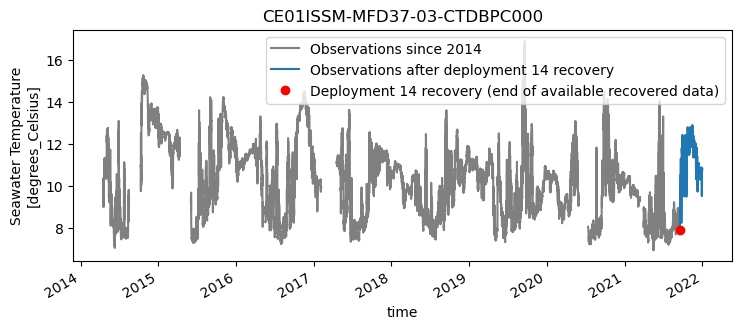

In [19]:
# plot time series of sea water temperature with matplotlib
data_recover14 = data_edit.sel(time='2021-09-17 14:00:00', method='nearest')
plt.figure(num=1, figsize=[8.5,3])
dataset_full['sea_water_temperature'].sel(time=slice('2014-01-01 00:00', '2022-01-01 00:00')).plot(color='gray')
dataset_full['sea_water_temperature'].sel(time=slice('2021-09-17 12:00', '2022-01-01 00:00')).plot()
plt.plot(data_recover14['time'], data_recover14['sea_water_temperature'],'ro')
plt.title(refdes)
plt.legend(['Observations since 2014', 'Observations after deployment 14 recovery', 'Deployment 14 recovery (end of available recovered data)'])

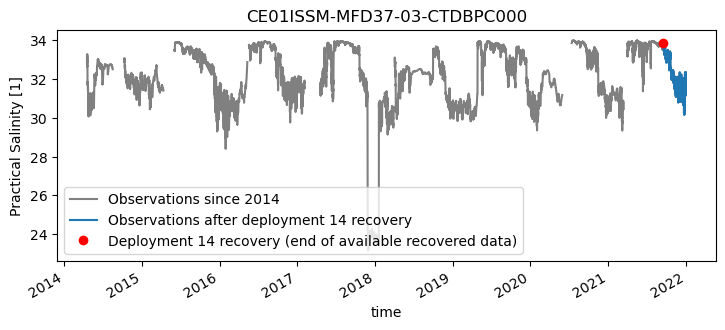

In [20]:
# plot time series of sea water practical salinity
data_recover14 = data_edit.sel(time='2021-09-17 14:00:00', method='nearest')
plt.figure(num=1, figsize=[8.5,3])
dataset_full['sea_water_practical_salinity'].sel(time=slice('2014-01-01 00:00', '2022-01-01 00:00')).plot(color='gray')
dataset_full['sea_water_practical_salinity'].sel(time=slice('2021-09-17 12:00', '2022-01-01 00:00')).plot()
plt.plot(data_recover14['time'], data_recover14['sea_water_practical_salinity'],'ro')
plt.title(refdes)
plt.legend(['Observations since 2014', 'Observations after deployment 14 recovery', 'Deployment 14 recovery (end of available recovered data)'])

Text(0.5, 1.0, 'CE01ISSM-MFD37-03-CTDBPC000')

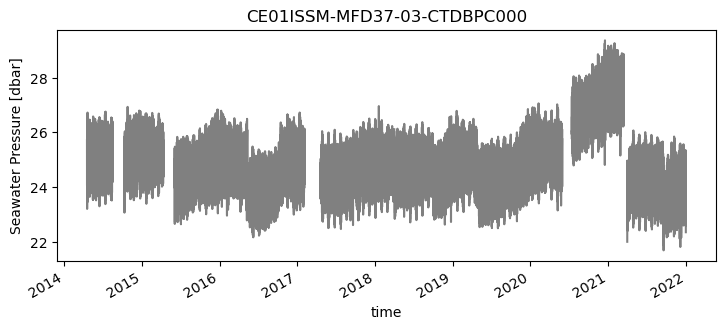

In [22]:
# plot time series of sea water pressure
# data_recover14 = data_edit.sel(time='2021-09-17 14:00:00', method='nearest')
plt.figure(num=1, figsize=[8.5,3])
dataset_full['sea_water_pressure'].sel(time=slice('2014-01-01 00:00', '2022-01-01 00:00')).plot(color='gray')
# dataset_full['sea_water_pressure'].sel(time=slice('2021-09-17 12:00', '2022-01-01 00:00')).plot()
# plt.plot(data_recover14['time'], data_recover14['sea_water_pressure'],'ro')
plt.title(refdes)
# plt.legend(['Observations since 2014', 'Observations after deployment 14 recovery', 'Deployment 14 recovery (end of available recovered data)'])

In [12]:
# Looking for explanations of extreme low in sea water temperature and practical salinity
# annotation 1892 above flags bad data from 11 Jan to 13 Jul 2020 which is why it isn't included here
# Checking data just before this and confirming that the flagged data starts when it should
print(dataset_full['sea_water_temperature'].sel(time=slice('2020-01-12 00:00', '2020-01-17 00:00')))

<xarray.DataArray 'sea_water_temperature' (time: 41)>
array([10.43238497, 10.344753  , 10.3499819 , 10.30779352,  8.79731622,
        8.64104935,  8.0620142 ,  7.52727097,  5.29015532,  3.553979  ,
        2.60435682,  2.58670612,  2.81412276,  2.86781083,  5.03883387,
        9.10404701,  9.61399723,  9.79221596, 11.43652085, 12.14952264,
       12.41202848, 11.48739015, 12.29805369, 12.82398887, 13.17285982,
               nan,         nan,         nan,         nan,         nan,
               nan,         nan,         nan,         nan,         nan,
               nan,         nan,         nan,         nan,         nan,
               nan])
Coordinates:
  * time     (time) datetime64[ns] 2020-01-12 2020-01-12T03:00:00 ... 2020-01-17
Attributes:
    comment:                   Seawater temperature near the sensor.
    long_name:                 Seawater Temperature
    precision:                 4
    coordinates:               time lat lon depth
    data_product_identifier:   TEMPWAT_

In [11]:
# Check values for rollup_annotations
# This is where I realized that not all flags were applied because there were still flags of 9 in the dataset when they should have been edited out
print(dataset_full['rollup_annotations_qc_results'].sel(time=slice('2020-01-01 00:00', '2020-01-12 00:00')))

<xarray.DataArray 'rollup_annotations_qc_results' (time: 89)>
array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 9., 9.])
Coordinates:
  * time     (time) datetime64[ns] 2020-01-01 2020-01-01T03:00:00 ... 2020-01-12
Attributes:
    comment:        These qc flags are a rollup summary which represents a Hu...
    long_name:      rollup qc_flag
    flag_values:    [1 2 3 4 9]
    flag_meanings:  pass not_evaluated suspect_or_of_high_interest fail missi...


In [23]:
# Removing data for both fail and "missing" flags (which include more than just missing)
data_edit = data_edit.where(data_edit.rollup_annotations_qc_results < 4)
dataset_full = nanfill_time_gaps(data_edit)

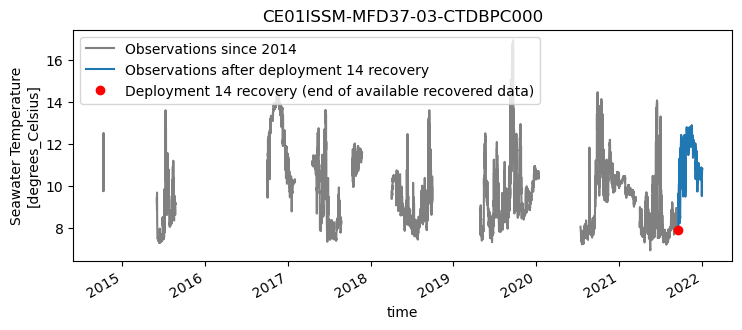

In [24]:
# Redo plot of sea water temperature after data editing
# This plot looks much more reasonable
data_recover14 = data_edit.sel(time='2021-09-17 14:00:00', method='nearest')
plt.figure(num=1, figsize=[8.5,3])
dataset_full['sea_water_temperature'].sel(time=slice('2014-01-01 00:00', '2022-01-01 00:00')).plot(color='gray')
dataset_full['sea_water_temperature'].sel(time=slice('2021-09-17 12:00', '2022-01-01 00:00')).plot()
plt.plot(data_recover14['time'], data_recover14['sea_water_temperature'],'ro')
plt.title(refdes)
plt.legend(['Observations since 2014', 'Observations after deployment 14 recovery', 'Deployment 14 recovery (end of available recovered data)'])

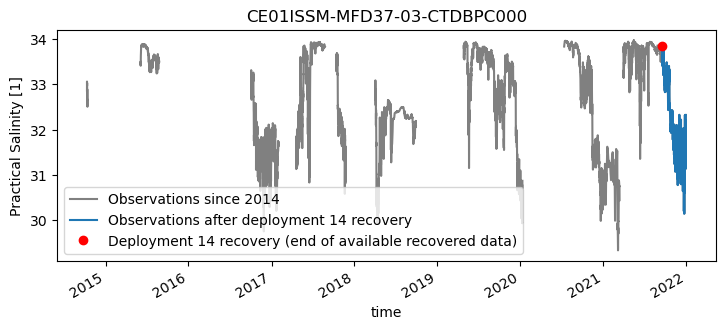

In [25]:
# Redo plot of practical salinity
# plot time series of sea water practical salinity
data_recover14 = data_edit.sel(time='2021-09-17 14:00:00', method='nearest')
plt.figure(num=1, figsize=[8.5,3])
dataset_full['sea_water_practical_salinity'].sel(time=slice('2014-01-01 00:00', '2022-01-01 00:00')).plot(color='gray')
dataset_full['sea_water_practical_salinity'].sel(time=slice('2021-09-17 12:00', '2022-01-01 00:00')).plot()
plt.plot(data_recover14['time'], data_recover14['sea_water_practical_salinity'],'ro')
plt.title(refdes)
plt.legend(['Observations since 2014', 'Observations after deployment 14 recovery', 'Deployment 14 recovery (end of available recovered data)'])

Text(0.5, 1.0, 'CE01ISSM-MFD37-03-CTDBPC000')

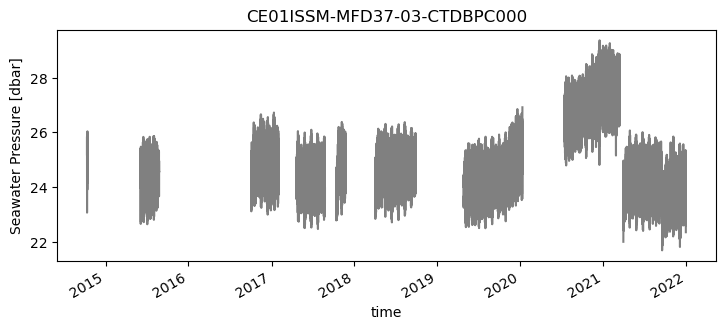

In [26]:
# Redo sea water pressure plot
plt.figure(num=1, figsize=[8.5,3])
dataset_full['sea_water_pressure'].sel(time=slice('2014-01-01 00:00', '2022-01-01 00:00')).plot(color='gray')
plt.title(refdes)

### Recalculate gross range and climatology test thresholds with "missing" data excluded

In [27]:
from ooi_data_explorations.qartod.endurance.qartod_ce_ctdbp import generate_qartod, ANNO_HEADER, CLM_HEADER, GR_HEADER
cut_off = '2021-01-01T00:00:00'

In [28]:
# create the QARTOD gross range and climatology lookup values and tables
# This is the part that needs to change - temporarily changed data editing condition in Chris W's functions to match figures I created above
# This change is in generate_qartod function in ooi_data_explorations/qartod/endurance/qartod_ce_ctdbp.py
annotations, gr_lookup, clm_lookup, clm_table = generate_qartod(site, node, sensor, cut_off)

Testing data for normality: sea_water_electrical_conductivity
[########################################] | 100% Completed | 1.57 sms
Testing data for normality: sea_water_temperature
[########################################] | 100% Completed | 1.67 sms
Testing data for normality: sea_water_pressure
[########################################] | 100% Completed | 1.57 sms
Testing data for normality: sea_water_practical_salinity
[########################################] | 100% Completed | 1.56 sms


In [29]:
# save the downloaded annotations and qartod lookups and tables
# added "revised" before refdes in all file names that we will save CSVs under
out_path = os.path.join(os.path.expanduser('~'), 'ooidata/qartod/ctdbp')
out_path = os.path.abspath(out_path)
if not os.path.exists(out_path):
    os.makedirs(out_path)

In [30]:
# save the annotations to a csv file for further processing
anno_csv = '-'.join(['revised', site, node, sensor]) + '.quality_annotations.csv'
annotations.to_csv(os.path.join(out_path, anno_csv), index=False, columns=ANNO_HEADER)

In [31]:
# save the gross range values to a csv for further processing
gr_csv = '-'.join(['revised', site, node, sensor]) + '.gross_range.csv'
gr_lookup.to_csv(os.path.join(out_path, gr_csv), index=False, columns=GR_HEADER)

In [32]:
# save the climatology values and table to a csv for further processing
clm_csv = '-'.join(['revised', site, node, sensor]) + '.climatology.csv'
clm_lookup.to_csv(os.path.join(out_path, clm_csv), index=False, columns=CLM_HEADER)
parameters = ['sea_water_temperature', 'practical_salinity']
for i in range(len(parameters)):
    tbl = '-'.join(['revised', site, node, sensor, parameters[i]]) + '.csv'
    with open(os.path.join(out_path, tbl), 'w') as clm:
        clm.write(clm_table[i])